# MF_Timestamp_Service(with mflib)

## Timestamp Service Overview

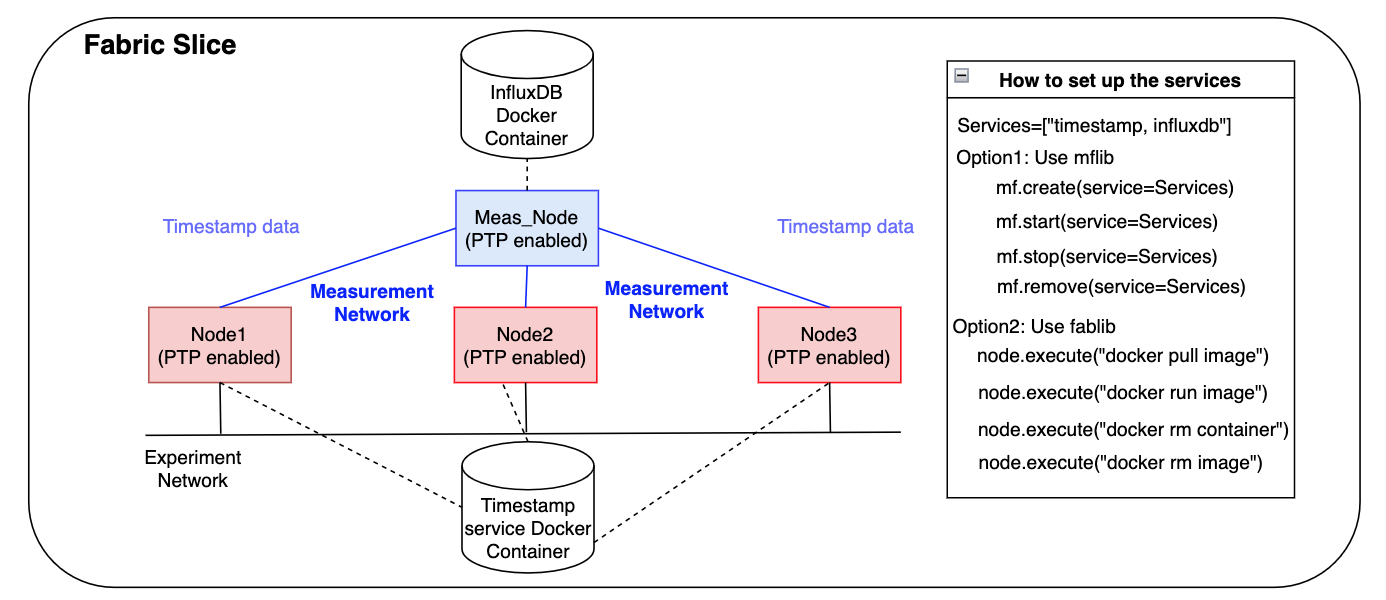

## Import

In [ ]:
import json
import os
import traceback
import importlib
import mflib 
print(f"MFLib version  {mflib.__version__} " )
from mflib.mflib import MFLib
from mflib.mf_timestamp import mf_timestamp 
#importlib.reload(mf_timestamp)
from fabrictestbed_extensions.fablib.fablib import fablib
from fabrictestbed_extensions.fablib.fablib import FablibManager as fablib_manager

## Slice Info

In [ ]:
# Change your slice name
slice_name="MyMonitoredSlice"
container_name="timestamp"
node1_name = 'Node1'
node2_name = 'Node2'
node3_name = 'Node3'

In [ ]:
%%time
mf = MFLib(slice_name)

## Find the Measurement Node and Experiment Nodes

In [ ]:
meas_node_name = "_meas_node"
try:
    slice = fablib.get_slice(name=slice_name)
except Exception as e:
    print(f"Fail: {e}")
try:
    meas_node = slice.get_node(name=meas_node_name)
    node1 = slice.get_node(name=node1_name)
    node2 = slice.get_node(name=node2_name)
    node3 = slice.get_node(name=node3_name)
except Exception as e:
    print(f"Fail: {e}")

## Check Whether the Nodes are on PTP-capable Sites 

In [ ]:
ptp_capable_sites=['STAR','MAX','MICH','MASS','UTAH','NCSA','UCSD','FIU','CLEM','CERN']
nodes_on_ptp_sites=[]
for node in slice.get_nodes():
    site=node.get_site()
    name=node.get_name()
    if (site in ptp_capable_sites):
        print (f"{name} on {site} is ptp capable")
        nodes_on_ptp_sites.append(node)
    else:
        print (f"{name} on {site} is not ptp capable")

## Check whether PTP is running

In [ ]:
# Check whether the software phc2sys of linuxptp is synchronizing clocks to the ptp device
for node in nodes_on_ptp_sites:
    print (node.get_name())
    node.execute("ps -ef | grep phc2sys")

## Setup timestamp service on nodes

### Pull the timestamp docker image to nodes (via ansible scripts on Measurement Node)

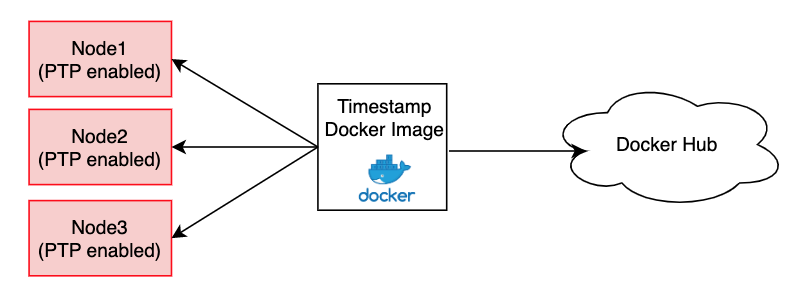

In [ ]:
%%time
mf.create(service="timestamp")

# Copies the timestamp Dockerfile from measurement node to each experiment node and builds the image

# Or alternatively pull the image from Fabric Docker Hub
# node1.execute("sudo docker pull fabrictestbed/timestamp:0.1.1")
# node2.execute("sudo docker pull fabrictestbed/timestamp:0.1.1")
# node3.execute("sudo docker pull fabrictestbed/timestamp:0.1.1")

### Run the timestamp docker image as a container on each experiment node

In [ ]:
# Runs the built image as Docker Container  
mf.start(services=["timestamp",])

# Or alternativly, 

#timestamp_bind_mount_volume = "/home/rocky/services/timestamp/output"
#cmd = f'''
#      sudo docker run -dit \
#      -v {timestamp_bind_mount_volume}:/root/services/timestamp/output_files/ \
#      --pid=host --network=host --privileged \
#      --name timestamp fabrictestbed/timestamp:0.1.1
#      '''
#node1.execute(cmd)
#node2.execute(cmd)
#node3.execute(cmd)

### Check on each node if timestamp docker container is running

In [ ]:
command = f"sudo docker ps"
stdout, stderr= node1.execute(command)
stdout, stderr= node2.execute(command)
stdout, stderr= node3.execute(command)

## Create the object and set experiment name

In [ ]:
ts = mf_timestamp(slice_name=slice_name, container_name=container_name)
packet_test_name = "packet_test"
event_test_name= "event_test"

### Record timestamp for packets
#### This method will trigger tcpdump to record packets and write results to file

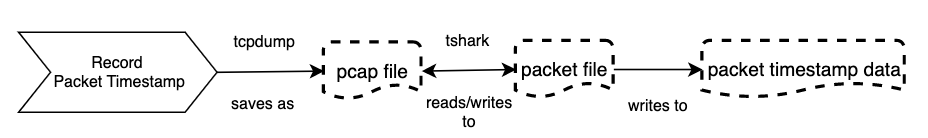

In [ ]:
# Need to Check the interface ens/eth on that node and pass as a parameter
# Prepare to run iperf from one experiment node to this experiment node in the terminal 
# e.g, On node1: sudo iperf3 -s    On node2: sudo iperf -c {node1_IP_address} -t 10 -b 1G
ts.record_packet_timestamp(node=node1_name,name=packet_test_name, interface="eth2",ipversion="6",
                           protocol="tcp", duration="10", verbose=True)

### Get the recorded packet timestamp from local file

In [ ]:
# May run into IOPub data rate exceeded error if you have large data
packet_records= ts.get_packet_timestamp(node=node1_name, name=packet_test_name)

### Download the timestamp data file from node1

In [ ]:
timestamp_volume= "/home/rocky/services/timestamp/output"
# Specify you Jupyterhub path
file_download_path="/home/fabric/work/packet_timestamp.json"
ts.download_timestamp_file(node=node1_name, data_type="packet_timestamp",
                           local_file=file_download_path,
                           bind_mount_volume=timestamp_volume)


### Inspect the data format from the downloaded file

In [ ]:
# A list of json objects, inspect the first object
with open(file_download_path, 'r') as f:
    result = json.load(f)
print (result[0])

### Local Data Visualization using matplotlib 

In [ ]:
ts.plot_packet_timestamp(json_obj=result)

### Record timestamp for events

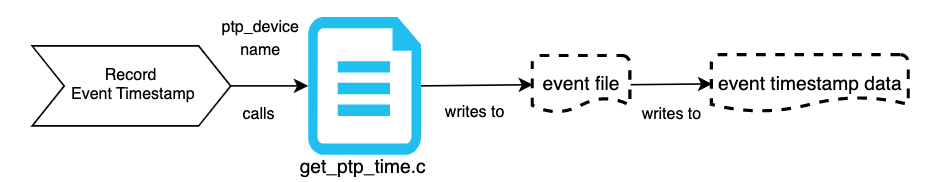

In [ ]:
# Put the name of the event
ts.record_event_timestamp(node=node1_name,name=event_test_name,event="'ram usage above 80 percent'", verbose=True)

### Get the recorded event timestamp

In [ ]:
event_records=ts.get_event_timestamp(node=node1_name,name=event_test_name)

## Setup influxdb service on measurement node

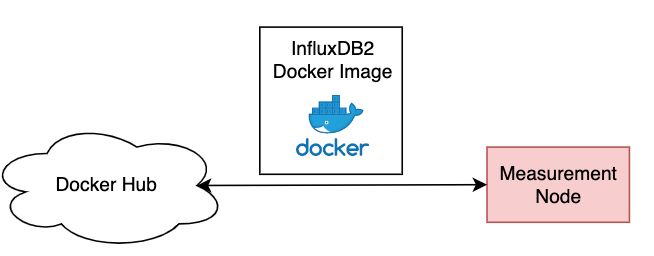

In [ ]:
# Pulls the influxdb 2.0 docker image on measurement node
mf.create(service="influxdb")

# Or alternatively,
#meas_node.execute("sudo docker pull influxdb:2.0")

### Check influxdb image

In [ ]:
meas_node.execute("sudo docker image ls")

### Run influxdb in the docker container on measurement node

In [ ]:
# Runs the pulled image as a container
mf.start(services=["influxdb",])

# Or alternatively,
#influxdb_bind_mount_volume="/home/ubuntu/influxdb"
#cmd = f'''
#      sudo docker run --privileged -d \
#      -v {influxdb_bind_mount_volume}:/var/lib/influxdb2 \
#      -e DOCKER_INFLUXDB_INIT_MODE=setup \
#      -e DOCKER_INFLUXDB_INIT_USERNAME=my-user \
#      -e DOCKER_INFLUXDB_INIT_PASSWORD=my-password \
#      -e DOCKER_INFLUXDB_INIT_ORG=my-org \
#      -e DOCKER_INFLUXDB_INIT_BUCKET=my-bucket \
#      --network=host --privileged \
#      --name influxdb influxdb:2.0
#      '''
# meas_node.execute(cmd)

### Check influxdb docker container on measurement node 

In [ ]:
command = f"sudo docker ps"
stdout, stderr= meas_node.execute(command)

## Get influxdb info from the measurement node

### List influxdb info

In [ ]:
print ("List buckets")
command = f"sudo docker exec influxdb influx bucket list -o my-org"
stdout, stderr= meas_node.execute(command)

print ("\nList orgs")
command = f"sudo docker exec influxdb influx org list --json"
stdout, stderr= meas_node.execute(command)
org_id = str(json.loads(stdout)[0]["id"])

print ("\nList tokens")
command = f"sudo docker exec influxdb influx auth list --json"
stdout, stderr= meas_node.execute(command)

## Upload data to influxdb

### Load influx info

In [ ]:
token = str(json.loads(stdout)[0]["token"])
bucket = "my-bucket"
org="my-org"  

### Upload packet and event data to influxdb

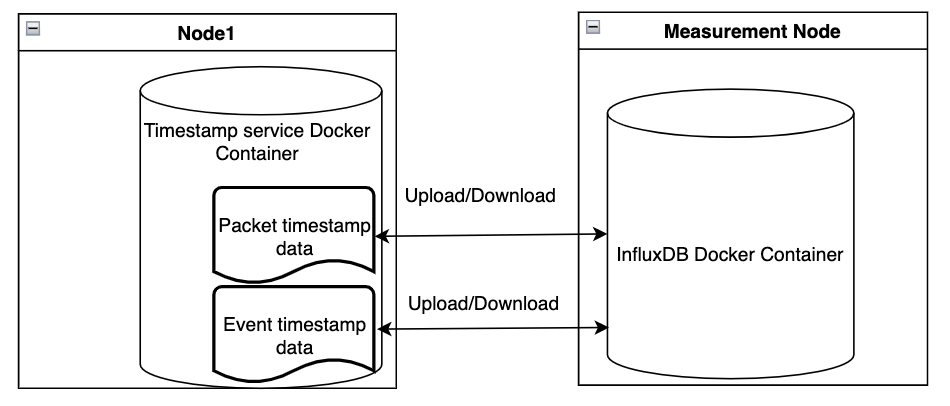

In [ ]:
ts.upload_timestamp_to_influxdb(node=node1_name, data_type="packet_data", bucket=bucket, org=org, token=token)

In [ ]:
ts.upload_timestamp_to_influxdb(node=node1_name, data_type="event_data", bucket=bucket, org=org, token=token)

## If you want to see the Json output

### Print packet data from influxdb

In [ ]:
# May run into IOPub data rate exceeded error if you have large data
ts.download_timestamp_from_influxdb(node=node1_name, data_type="packet_data", 
                                    bucket=bucket, org=org, token=token, name=packet_test_name)

### Generate a .csv data file based on query

In [ ]:
# query the data based on the name of the measurement and experiment. Write the results to a CSV file
ts.generate_csv_on_influxdb_node(data_node=node1_name, name=packet_test_name, data_type="packet_timestamp", 
                                    bucket=bucket, org=org, token=token,influxdb_node_name="_meas_node")

### Download the .csv file to jupyterhub

In [ ]:
local_file=f"/home/fabric/work/influxdb_{node1_name}_packet_timestamp.csv"
ts.download_file_from_influxdb(data_node=node1_name, data_type="packet_timestamp", influxdb_node_name="_meas_node",
                               local_file=local_file)

### Inspect the data from the .csv file

In [ ]:
import pandas as pd
df = pd.read_csv (local_file)
print(df.iloc[0])

### Print event data

In [ ]:
ts.download_timestamp_from_influxdb(node=node1_name, data_type="event_data", 
                                    bucket=bucket, org=org, token=token, name=event_test_name)

## Visualize the influxdb web UI

In [ ]:
# Set up ssh tunneling and provide the local port number
# ssh -L 9999:localhost:8086 -F ~/.ssh/fabric_ssh_config -i ~/.ssh/fabric_slice_key ubuntu@meas_node_ip 
port="9999"
URL=f"http://localhost:{port}/orgs/{org_id}/data-explorer?bucket={bucket}"
print (URL)

In [ ]:
# Visualize the Influxdb web ui in the output cell. username: my-user , password: my-password
from IPython.display import IFrame
IFrame(URL, width=1200, height=800)

### Upload a custom dashboard

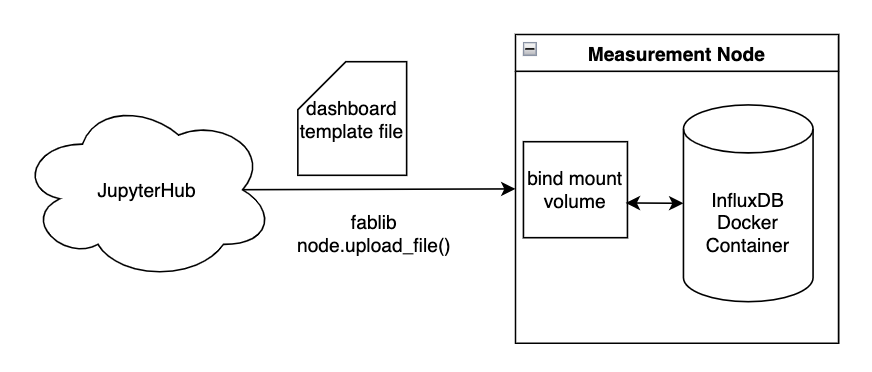

In [ ]:
# Use mf_timestamp
cwd = os.getcwd()
dashboard_file_relative_path = "dashboard_examples/influxdb/influxdb_timestamp_dashboard.yml"
dashboard_file_real_path = os.path.join(cwd, dashboard_file_relative_path)
ts.deploy_influxdb_dashboard(dashboard_file=dashboard_file_real_path, 
                             influxdb_node_name="_meas_node",
                             bind_mount_volume="/home/ubuntu/influxdb")

# Or
# Upload the dashboard file to the directory on meas_node that binds mount on influxdb container
#meas_node.upload_file(local_file_path=dashboard_file_real_path, remote_file_path="/home/mfuser/influxdb/dashboard.yml")

# Apply the template in influxdb 
#command = f"sudo docker exec -i influxdb influx apply --skip-verify --file /var/lib/influxdb2/dashboard.yml"
#stdout, stderr= meas_node.execute(command)

## Stop the services 

In [ ]:
# Use mflib to stop the timestamp container
mf.stop(services=["timestamp",])

# Or alternatively,
#stdout=node1.execute("sudo docker ps -aqf 'name=timestamp'", quiet=True)
#timestamp_container_id=stdout[0]
#stdout,stderr= node1.execute(f"sudo docker container stop {timestamp_container_id}", quiet=True)

In [ ]:
# Use mflib to stop the influxdb container
mf.stop(services=["influxdb",])

# Or alternatively,
#stdout=meas_node.execute("sudo docker ps -aqf 'name=influxdb'", quiet=True)
#influxdb_container_id=stdout[0]
#stdout,stderr= meas_node.execute(f"sudo docker container stop {influxdb_container_id}", quiet=True)


## Remove the services

In [ ]:
# Use mflib to stop the timestamp container
mf.remove(services=["timestamp",])

# Or alternatively,
#stdout,stderr= node3.execute(f"sudo docker rm -v timestamp", quiet=True)

# Remove the timestamp docker image
#stdout,stderr= node3.execute("sudo docker rmi -f fabrictestbed/timestamp:0.1.1")

# Remove the bind mount volume
#stdout,stderr= node3.execute(f"sudo rm -rf {timestamp_bind_mount_volume}")

In [ ]:
# Use mflib to stop the influxdb container
mf.remove(services=["influxdb",])

# Or alternatively,
#stdout,stderr= meas_node.execute(f"sudo docker rm -v influxdb", quiet=True)

# Remove the influxdb docker image
#stdout,stderr= meas_node.execute("sudo docker rmi -f influxdb:2.0")

# Remove the bind mount volume
#stdout,stderr= meas_node.execute(f"sudo rm -rf {influxdb_bind_mount_volume}")

In [ ]:
for node in [node1, node2, node3]:
    stdout,stderr= node.execute("sudo docker ps -a")
    stdout,stderr= node.execute("sudo docker image ls")

In [ ]:
# No influxdb
stdout,stderr= meas_node.execute("sudo docker ps -a")
stdout,stderr= meas_node.execute("sudo docker image ls")